In [2]:
from google.colab import drive
drive.mount('/content/mydrive')

Drive already mounted at /content/mydrive; to attempt to forcibly remount, call drive.mount("/content/mydrive", force_remount=True).


In [3]:
import os
import cv2
from PIL import Image
import numpy as np

In [4]:
image_dir = "/content/mydrive/My Drive/BrainTumorDetection/Dataset/"
output_dir = "/content/mydrive/My Drive/BrainTumorDetection/Model/"
image_shape = (64,64)

In [5]:
try:
  no_tumor_image_list = os.listdir(image_dir+'no/')
  tumor_image_list = os.listdir(image_dir+'yes/')

  print(("{:<25}"*2).format("Images with no tumor:",len(no_tumor_image_list)))
  print(("{:<25}"*2).format("Images with tumor:",len(tumor_image_list)))
  print(("{:<25}"*2).format("Total number of images: ",len(no_tumor_image_list)+len(tumor_image_list)))
except FileNotFoundError as fe:
  print(fe) 

Images with no tumor:    1500                     
Images with tumor:       1500                     
Total number of images:  3000                     


# **Pre-Processing**
> **Only '.jpg' image**

> **Resize (64x64)**

> **Reflect (x-axis, y-axis, both-axis)**

> **Rotate (90deg, 270deg)**

In [6]:
def img_read_and_resize(image_dir,folder,image_name):
  """
  To read and resize dataset image
  ...
  Parameters
  ----------
    image_dir: Path to directory
    folder: Folder name
    image_name: Image name
  Return
  ------
    resized image
  """
  try:
    image = cv2.imread(image_dir+folder+image_name)
    image = Image.fromarray(image)
    image = image.resize(image_shape)
    return image
  except Exception as e:
    print(e)

def rotate_img(image,deg):
  """
  To rotate image 90 and 270 deg
  ...
  Parameters
  ----------
    image: Image to rotate
    deg: Degree for rotation (90 or 270)
  Return
  ------
    (deg) degree transposed image->image
  """
  if deg == 90:
    return image.transpose(Image.ROTATE_90)
  elif deg == 270:
    return image.transpose(Image.ROTATE_270)

def reflect_img(image, axis):
  """
  To Reflect the image
  ...
  Parameters
  ----------
    image: Image to reflect
    axis: axis to flip along [0:y-axis, 1: x-axis, -1: both axis]
  Return
  ------
    Reflected image along 'axis' axis
  """ 
  if axis == 0:
    return image.transpose(Image.FLIP_TOP_BOTTOM)
  elif axis == 1:
    return image.transpose(Image.FLIP_LEFT_RIGHT)
  elif axis == -1:
    x_ref = image.transpose(Image.FLIP_LEFT_RIGHT)
    return x_ref.transpose(Image.FLIP_TOP_BOTTOM)

def append_result(image,status,dataset,label):
  """
  To append transposed image to dataset and corresponding label status
  ...
  Parameters
  ----------
    image: Image to rotate, reflect and append
    status: Label 0 or 1
    dataset: Dataset list
    label: Label list
  """
  dataset.append(np.array(image))
  label.append(status)
  #Rotate
  rot90 = rotate_img(image,90)
  dataset.append(np.array(rot90))
  label.append(status)
  rot270 = rotate_img(image,270)
  dataset.append(np.array(rot270))
  label.append(status)
  #Reflect
  x_ref = reflect_img(image,1)
  dataset.append(np.array(x_ref))
  label.append(status)
  y_ref = reflect_img(image,0)
  dataset.append(np.array(y_ref))
  label.append(status)
  b_ref = reflect_img(image,-1)
  dataset.append(np.array(b_ref))
  label.append(status)

def get_preprocessed_data(image_dir,no_tumor_image_list,tumor_image_list):
  """
    To create dataset and label
    ...
    Parameter
    ---------
      image_dir: Path to directory
      no_tumor_image_list: List of images with no tumor
      tumor_image_list: List of images with tumor
    Return
    ------
      dataset: Dataset list
      label: Label list
  """
  dataset=[]
  label=[]
  for image_name in no_tumor_image_list:
      if ".jpg" in image_name:
          image = img_read_and_resize(image_dir,'no/',image_name)
          append_result(image,0,dataset,label)

  for image_name in tumor_image_list:
      if ".jpg" in image_name:
          image = img_read_and_resize(image_dir,'yes/',image_name)
          append_result(image,1,dataset,label)
  return dataset, label
            
dataset, label = get_preprocessed_data(image_dir,no_tumor_image_list,tumor_image_list)
        
dataset = np.array(dataset)
label = np.array(label)

print(("{:<18}"*2).format("Total Dataset shape:",str(dataset.shape)))

Total Dataset shape:(18000, 64, 64, 3)


# CNN

In [7]:
import tensorflow as tf 
from tensorflow import keras 
from keras.models import Sequential
from keras.layers import Activation, Conv2D, Dense, Dropout, Flatten, MaxPooling2D
from sklearn.model_selection import train_test_split


In [8]:
def normalize(x, axis=1):
  """
    Normalizes the numpy array 'x'
    ...
    Parameters
    ----------
      x: Numpy array to normalize
      axis: Axis along which normalization is done
    Return
    ------
      A noralized numpy array
  """
  norm = np.linalg.norm(x, ord=2, axis=axis)  # ord=2 -> L2 Normalization
  l2 = np.atleast_1d(norm)
  l2[l2 == 0] = 1 #every element with value 0 to 1 .. else: NAN
  return x / np.expand_dims(l2, axis)

In [9]:
x_train, x_test, y_train, y_test = train_test_split(dataset, label, test_size=0.2)
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=0.5)
x_train = normalize(x_train,axis=1)
x_test = normalize(x_test,axis=1)
x_val = normalize(x_val,axis=1)
y_train = np.array(y_train)
y_test = np.array(y_test)
y_val = np.array(y_val)
 
print('Training Dataset shape:\t\t', x_train.shape)
print('Training label size:\t\t', y_train.shape)
print('Validation Dataset shape:\t', x_val.shape)
print('Validation label size:\t\t', y_val.shape)
print('Testing Dataset shape:\t\t', x_test.shape)
print('Testing label size:\t\t', y_test.shape)


Training Dataset shape:		 (14400, 64, 64, 3)
Training label size:		 (14400,)
Validation Dataset shape:	 (1800, 64, 64, 3)
Validation label size:		 (1800,)
Testing Dataset shape:		 (1800, 64, 64, 3)
Testing label size:		 (1800,)


# Model Building

In [10]:
model = Sequential()

model.add(Conv2D(32,(3,3),input_shape=(image_shape[0],image_shape[1],3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64,(3,3),kernel_initializer='he_uniform'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(128,(3,3),kernel_initializer='he_uniform'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        896       
                                                                 
 activation (Activation)     (None, 62, 62, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 activation_1 (Activation)   (None, 29, 29, 64)        0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                    

In [11]:
history=model.fit(x_train,y_train,verbose=1,batch_size=16,validation_data=(x_test,y_test),epochs=10)
# model.save(output_dir+"TumorModel10Epochs-128.h5")

Epoch 1/10
900/900 [==============================] - 102s 113ms/step - loss: 0.3911 - accuracy: 0.8303 - val_loss: 0.1738 - val_accuracy: 0.9311
Epoch 2/10
900/900 [==============================] - 106s 118ms/step - loss: 0.1363 - accuracy: 0.9577 - val_loss: 0.0811 - val_accuracy: 0.9711
Epoch 3/10
900/900 [==============================] - 103s 114ms/step - loss: 0.0678 - accuracy: 0.9790 - val_loss: 0.0712 - val_accuracy: 0.9811
Epoch 4/10
900/900 [==============================] - 102s 113ms/step - loss: 0.0399 - accuracy: 0.9874 - val_loss: 0.0678 - val_accuracy: 0.9844
Epoch 5/10
900/900 [==============================] - 102s 114ms/step - loss: 0.0302 - accuracy: 0.9903 - val_loss: 0.0685 - val_accuracy: 0.9872
Epoch 6/10
900/900 [==============================] - 102s 113ms/step - loss: 0.0193 - accuracy: 0.9937 - val_loss: 0.0641 - val_accuracy: 0.9811
Epoch 7/10
900/900 [==============================] - 103s 114ms/step - loss: 0.0168 - accuracy: 0.9947 - val_loss: 0.0671 -

In [12]:
loss, acc = model.evaluate(x_test, y_test,verbose=1, batch_size= 16)
print('Test Accuracy:','%.5f'% acc)
print('Test Loss:', '%.5f'% loss)

113/113 [==============================] - 4s 31ms/step - loss: 0.1100 - accuracy: 0.9856
Test Accuracy: 0.98556
Test Loss: 0.11000


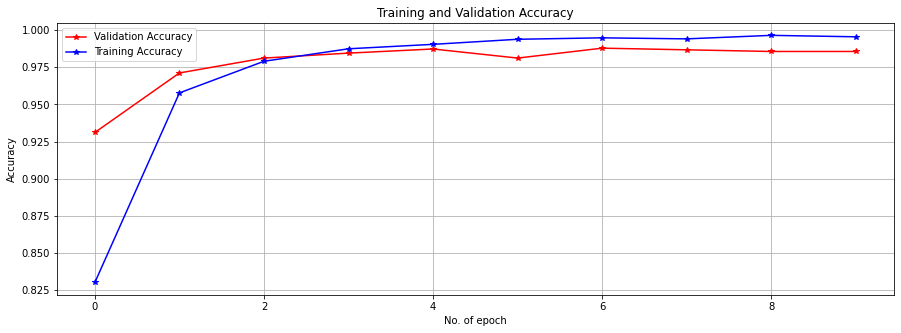

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))
val_acc, = plt.plot(history.history['val_accuracy'],'r*-', label='Validation Accuracy')
acc, = plt.plot(history.history['accuracy'],'b*-', label='Training Accuracy')
plt.grid()
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('No. of epoch')
plt.legend(handles=[val_acc, acc])
plt.show()

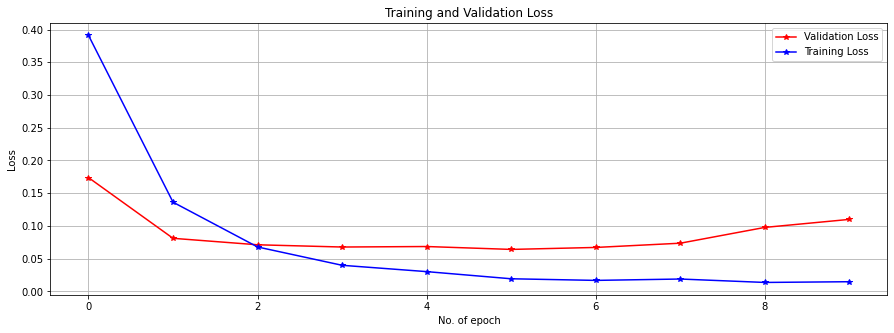

In [14]:
plt.figure(figsize=(15, 5))
val_loss, = plt.plot(history.history['val_loss'],'r*-', label='Validation Loss')
loss, = plt.plot(history.history['loss'],'b*-', label='Training Loss')
plt.grid()
plt.title('Training and Validation Loss')
plt.ylabel('Loss')
plt.xlabel('No. of epoch')
plt.legend(handles=[val_loss, loss])
plt.show()

In [15]:
x_test_pred = model.predict(x=x_val,batch_size=16,verbose=1) 
x_test_pred[x_test_pred>=0.5] = 1
x_test_pred[x_test_pred<0.5] = 0 

113/113 [==============================] - 4s 31ms/step


Accuracy on validation set:  0.98500


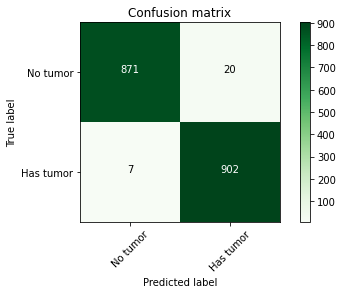

In [16]:
from sklearn.metrics import confusion_matrix, classification_report
import itertools
import matplotlib.pyplot as plt

cm=confusion_matrix(y_true=y_val,y_pred=x_test_pred)

def plot_confusion_matrix(cm, classes,cmap=plt.cm.Greens):
    """
    To prints and plots the confusion matrix.
    ...
    Parameters
    ----------
      cm: Confusion Matrix
      classes: Label class
      cmp: colormap
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title("Confusion matrix")
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    acc=(cm[0,0] + cm[1,1])/np.sum(cm)
    print("Accuracy on validation set: ", "%.5f"%acc)

cm_plot_labels = ['No tumor','Has tumor']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels)

In [17]:
print("="*20,"Classification Report","="*20,end="\n\n")
print(classification_report(y_val,x_test_pred))

==================== Classification Report ====================

              precision    recall  f1-score   support

           0       0.99      0.98      0.98       891
           1       0.98      0.99      0.99       909

    accuracy                           0.98      1800
   macro avg       0.99      0.98      0.98      1800
weighted avg       0.99      0.98      0.98      1800



Cross Validation

In [18]:
from keras.callbacks import ModelCheckpoint, EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
model_checkpoint = ModelCheckpoint(output_dir+'BrainTumorModel-10FoldValidation.h5', verbose=1, save_best_only=True)
def fit_and_evaluate(train_x, test_x, train_y, test_y, EPOCHS=10, BATCH_SIZE=16):
    results = model.fit(train_x, train_y, epochs=EPOCHS, batch_size=BATCH_SIZE,callbacks=[early_stopping, model_checkpoint],verbose=1, validation_split=0.1)  
    fold_loss, fold_acc= model.evaluate(test_x,test_y)
    print("Score:")
    print("Validation Loss:",fold_loss)
    print("Validation Accuracy:",fold_acc)
    return results

In [19]:
n_folds=10
epochs=10
batch_size=32
history_cfold = [] 

for i in range(n_folds):
    print("Training on Fold: ",i+1)
    train_x, test_x, train_y, test_y = train_test_split(x_train, y_train, test_size=0.2, random_state = np.random.randint(1,1000, 1)[0])
    history_cfold.append(fit_and_evaluate(train_x, test_x, train_y, test_y, epochs, batch_size))
    print("======="*10, end="\n\n\n")

Training on Fold:  1
Epoch 1/10
324/324 [==============================] - ETA: 0s - loss: 0.0046 - accuracy: 0.9986
Epoch 00001: val_loss improved from inf to 0.00078, saving model to /content/mydrive/My Drive/BrainTumorDetection/Model/BrainTumorModel-10FoldValidation.h5
324/324 [==============================] - 71s 217ms/step - loss: 0.0046 - accuracy: 0.9986 - val_loss: 7.7892e-04 - val_accuracy: 1.0000
Epoch 2/10
324/324 [==============================] - ETA: 0s - loss: 0.0019 - accuracy: 0.9994
Epoch 00002: val_loss improved from 0.00078 to 0.00026, saving model to /content/mydrive/My Drive/BrainTumorDetection/Model/BrainTumorModel-10FoldValidation.h5
324/324 [==============================] - 68s 210ms/step - loss: 0.0019 - accuracy: 0.9994 - val_loss: 2.5725e-04 - val_accuracy: 1.0000
Epoch 3/10
324/324 [==============================] - ETA: 0s - loss: 0.0012 - accuracy: 0.9996
Epoch 00003: val_loss improved from 0.00026 to 0.00013, saving model to /content/mydrive/My Drive/B

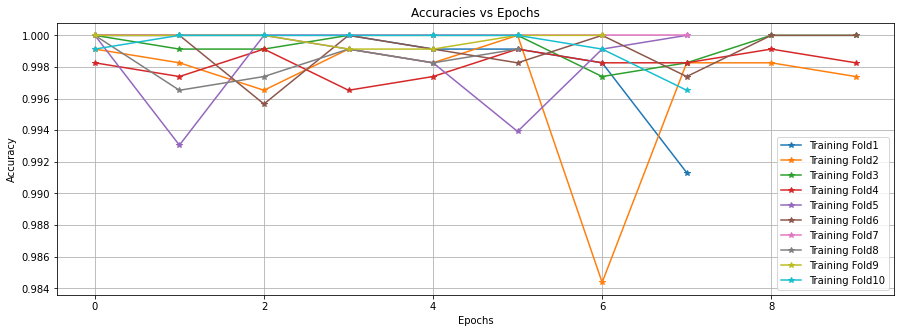

In [85]:
plt.figure(figsize=(15,5))
plt.title('Accuracies vs Epochs')
plt.grid()
for i in range(10):
  plt.plot(history_cfold[i].history['val_accuracy'],'*-', label=('Training Fold'+str(i+1)))
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

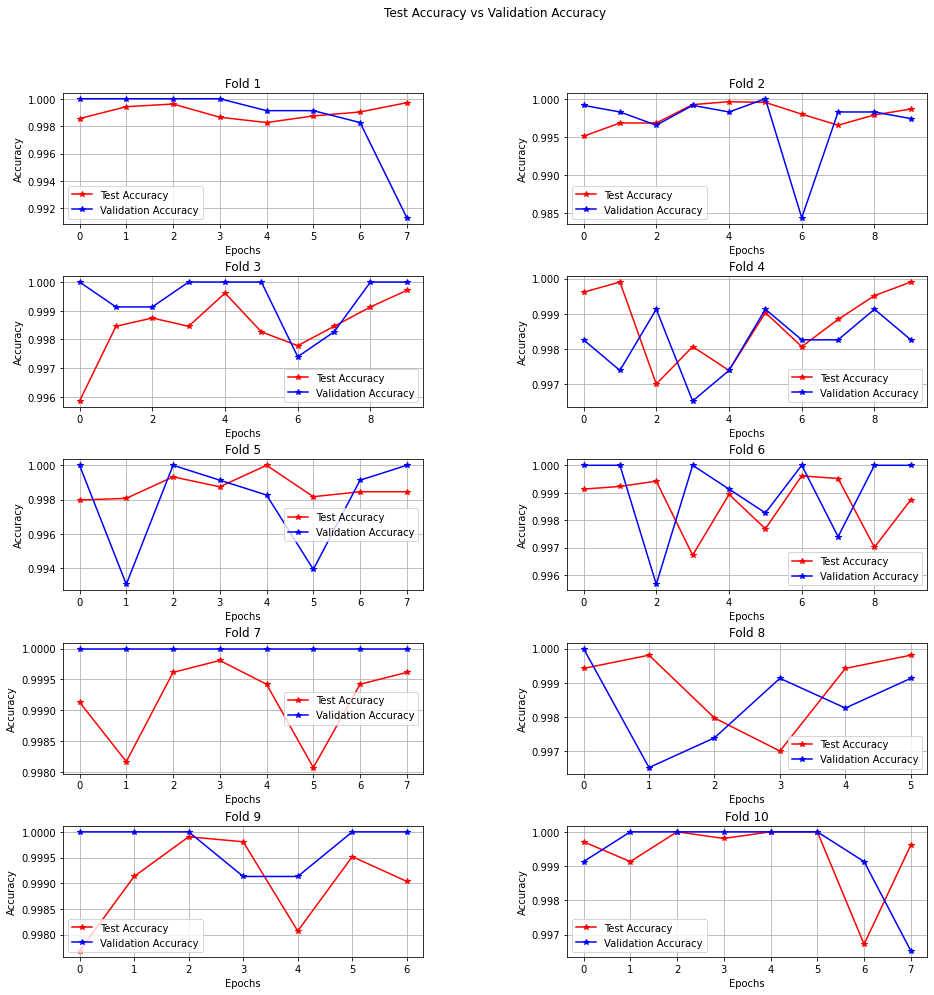

In [22]:
plt.figure(figsize=(15,15))
plt.suptitle("Test Accuracy vs Validation Accuracy")

for i in range(10):  
  plt.subplot(5,2,i+1,title=("Fold "+str(i+1)))     
  plt.grid()  
  plt.plot(history_cfold[i].history['accuracy'],'r*-', history_cfold[i].history['val_accuracy'],'b*-')
  plt.xlabel("Epochs")
  plt.ylabel("Accuracy")
  plt.legend(['Test Accuracy', 'Validation Accuracy'])
  plt.subplots_adjust(left=0.1,bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.4)
plt.show()

In [66]:
val_accuracy=[ 0.996874988079071,0.9986110925674438,0.9986110925674438,0.9982638955116272,0.9993055462837219,0.9993055462837219,0.9996528029441833,0.9996528029441833,0.9996528029441833,0.9989583492279053]
val_loss=[0.009240277111530304,0.00363092590123415,0.006562444847077131,0.006340328138321638,0.0057449908927083015,0.003230620175600052,0.0006402955041266978,0.0010451569687575102,0.0008684589411132038, 0.0026256779674440622]

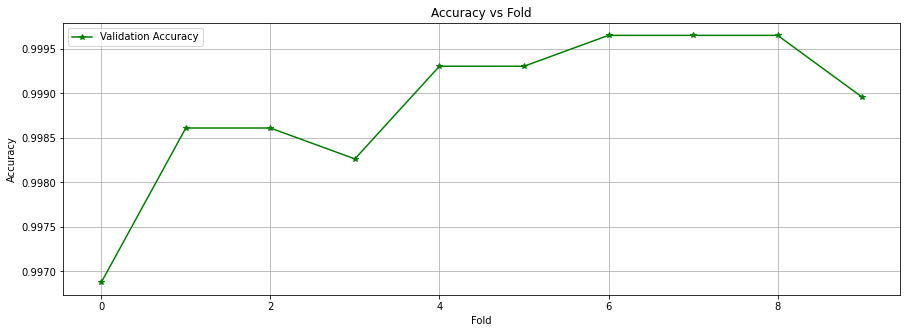

In [67]:
plt.figure(figsize=(15, 5))
val_acc, = plt.plot(val_accuracy,'g*-', label='Validation Accuracy')
plt.grid()
plt.title('Accuracy vs Fold')
plt.ylabel('Accuracy')
plt.xlabel('Fold')
plt.legend(handles=[val_acc])
plt.show() 

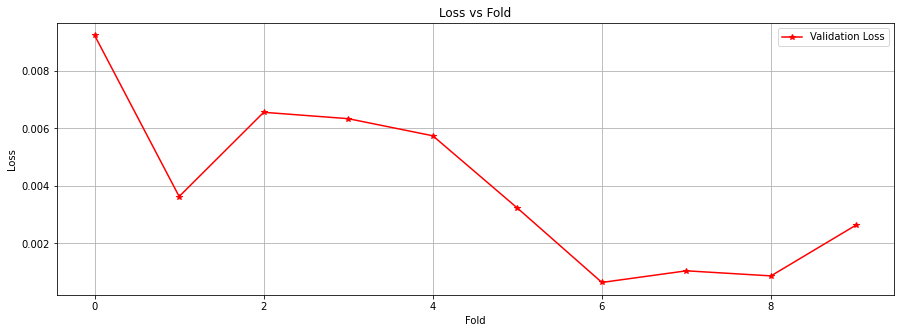

In [71]:
plt.figure(figsize=(15, 5))
val_acc, = plt.plot(val_loss,'r*-', label='Validation Loss')
plt.grid()
plt.title('Loss vs Fold')
plt.ylabel('Loss')
plt.xlabel('Fold')
plt.legend(handles=[val_acc])
plt.show() 

In [87]:
from keras.models import load_model
pre_model = load_model(output_dir+"BrainTumorModel-10FoldValidation.h5")
test_set_loss,test_set_acc = pre_model.evaluate(x_test,y_test)
val_set_loss,val_set_acc = pre_model.evaluate(x_val,y_val)
print("="*10,"Result","="*10)
print("Model Loss:",(test_set_loss+val_set_loss)/2)
print("Model Accuracy:",(test_set_acc+val_set_acc)/2)

57/57 [==============================] - 3s 60ms/step - loss: 0.0211 - accuracy: 0.9989
========== Result ==========
Model Loss: 0.021244805306196213
Model Accuracy: 0.9988889098167419


In [75]:
# !pip install shap
import shap
img_n = 170
explainer = shap.GradientExplainer(pre_model, x_train)
# we explain the model's predictions on the random three samples of the test set
shap_values = explainer.shap_values(x_test[img_n:img_n+3])

`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


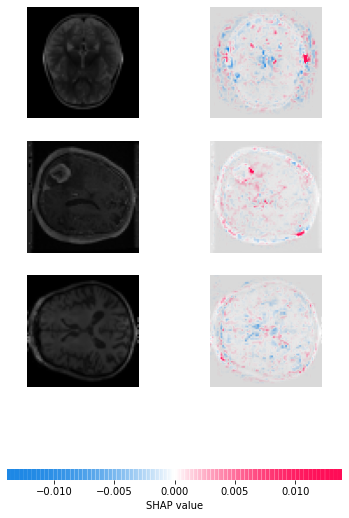

In [76]:
shap.image_plot(shap_values, x_test[img_n:img_n+3])

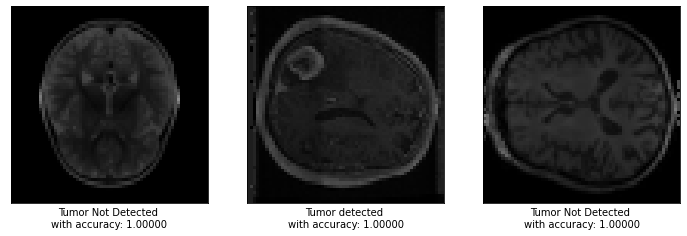

In [77]:
import numpy as np
import matplotlib.pyplot as plt
from keras.models import load_model

try:
  threshold = 0.5 
  pred_model = load_model(output_dir+"/BrainTumorModel-10FoldValidation.h5") 
  pred_imgs = x_test[img_n:img_n+3] 

  plt.figure(figsize=(12,5)) 
  for i in range(len(pred_imgs)): 
    image_to_predict=np.expand_dims(pred_imgs[i], axis=0) 
    result= pred_model.predict(image_to_predict)

    plt.subplot(1,3,i+1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(pred_imgs[i])
    if result[0][0] > threshold: 
      plt.xlabel("Tumor detected \nwith accuracy: %.5f"%result[0][0])
    else:
      plt.xlabel("Tumor Not Detected \nwith accuracy: %.5f"%(1-result[0][0]))
  plt.show()
except FileNotFoundError as fe:
  print(fe)
except NameError as ne:
  print(ne)